In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime
from typing import Union
import logging
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def extract_test_data(entity):
    
    query = f"""
        SELECT des.entity_id
            ,des.test_id
            ,des.test_start_date
            ,des.test_end_date
            ,des.variation_group
            ,des.variation_share
        FROM `fulfillment-dwh-production.cl.dps_experiment_setups` des
        WHERE des.test_start_date > '2024-01-01'
        AND date(des.test_end_date) < current_date()
        AND des.entity_id = '{entity}' 
        AND test_start_date is not null
        --AND test_id > 5
        GROUP BY 1,2,3,4,5,6
        ORDER BY des.entity_id, des.test_start_date
    """
    
    return query


def get_all_pairs():

    query = """
    
    WITH test_data AS (
        SELECT DISTINCT
        u.entity_id,
        CASE
        WHEN LEFT(SPLIT(CAST(u.test_id AS STRING), '_')[SAFE_OFFSET(0)], 2) = 'GV'
        THEN customer_id
        ELSE u.perseus_client_id
        END AS customer_id,
        CAST(u.test_id AS INT64) AS test_id,
        LOWER(u.test_variant) AS test_variant
        FROM `fulfillment-dwh-production.cl.dps_test_users` u
        JOIN `fulfillment-dwh-production.cl.dps_experiment_setups` e
        ON u.entity_id = e.entity_id
        AND u.test_id = e.test_id
        WHERE DATE(e.test_start_date) >= "2024-01-01"
        AND e.experiment_type = "AB"
        ),

        test_pairs AS (
        SELECT
        t1.entity_id,
        t1.test_id AS test_id_1,
        t2.test_id AS test_id_2
        FROM (SELECT DISTINCT entity_id, test_id FROM test_data) t1
        JOIN (SELECT DISTINCT entity_id, test_id FROM test_data) t2
        ON t1.entity_id = t2.entity_id
        AND t1.test_id < t2.test_id
        ),

        pivoted_data AS (
        SELECT
        entity_id,
        customer_id,
        test_id,
        COUNT(DISTINCT CASE WHEN test_variant = "control" THEN customer_id END) AS is_control,
        COUNT(DISTINCT CASE WHEN test_variant LIKE '%variation%' THEN customer_id END) AS is_variation
        FROM test_data
        GROUP BY entity_id, customer_id, test_id
        ),

        filtered_users AS (
        SELECT entity_id, customer_id, test_id
        FROM pivoted_data
        WHERE (is_control = 1 OR is_variation = 1)
        AND NOT (is_control = 1 AND is_variation = 1)
        ),

        user_variants AS (
        SELECT
        f.entity_id,
        f.customer_id,
        f.test_id,
        CASE
        WHEN p.is_control = 1 THEN "Control"
        WHEN p.is_variation = 1 THEN "Variation"
        END AS assigned_variant
        FROM filtered_users f
        JOIN pivoted_data p
        ON f.customer_id = p.customer_id
        AND f.test_id = p.test_id
        AND f.entity_id = p.entity_id
        ),

        filtered_test_pairs AS (
        SELECT
        u1.entity_id,
        u1.customer_id,
        tp.test_id_1,
        tp.test_id_2,
        u1.assigned_variant AS variant_1,
        u2.assigned_variant AS variant_2
        FROM test_pairs tp
        JOIN user_variants u1
        ON u1.entity_id = tp.entity_id
        AND u1.test_id = tp.test_id_1
        JOIN user_variants u2
        ON u2.entity_id = tp.entity_id
        AND u2.test_id = tp.test_id_2
        AND u1.customer_id = u2.customer_id
        ),

        overlap_analysis AS (
        SELECT
        entity_id,
        test_id_1,
        test_id_2,
        COUNT(DISTINCT customer_id) AS total_users_in_both,
        SUM(CASE WHEN variant_1 = "Control" AND variant_2 = "Control" THEN 1 ELSE 0 END) AS same_control,
        SUM(CASE WHEN variant_1 = "Variation" AND variant_2 = "Variation" THEN 1 ELSE 0 END) AS same_variation,
        SUM(CASE WHEN variant_1 = variant_2 THEN 1 ELSE 0 END) AS same_variant_both_tests
        FROM filtered_test_pairs
        GROUP BY entity_id, test_id_1, test_id_2
        )

        SELECT
        entity_id,
        test_id_1,
        test_id_2,
        total_users_in_both,
        same_control,
        same_variation,
        same_variant_both_tests,
        ROUND(same_variant_both_tests / NULLIF(total_users_in_both, 0), 2) AS overlap_ratio,
        ROUND(same_control / NULLIF(total_users_in_both, 0), 2) AS control_overlap_ratio,
        ROUND(same_variation / NULLIF(total_users_in_both, 0), 2) AS variation_overlap_ratio
        FROM overlap_analysis
        WHERE total_users_in_both > 1000
        ORDER BY entity_id, test_id_1, test_id_2;
     
    """

    return query


def impact_estimation(entity, test_1, test_2):

    query = f"""
            WITH test_data AS (
            SELECT
                entity_id,
                (CASE 
                    WHEN entity_id LIKE '%GV%' THEN customer_id 
                    ELSE perseus_client_id 
                END) AS perseus_client_id,
                CAST(test_id AS INT64) AS test_id,
                LOWER(test_variant) AS test_variant
            FROM `fulfillment-dwh-production.cl.dps_test_users`
            WHERE entity_id = '{entity}'
            AND test_id IN ({test_1}, {test_2})
        ),
        pivoted_data AS (
            SELECT
                entity_id,
                perseus_client_id,
                MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) = 'control' THEN 1 ELSE 0 END) AS is_control_A,
                MAX(CASE WHEN test_id = {test_1} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_A,
                MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) = 'control' THEN 1 ELSE 0 END) AS is_control_B,
                MAX(CASE WHEN test_id = {test_2} AND lower(test_variant) LIKE '%variation%' THEN 1 ELSE 0 END) AS is_variation_B
            FROM test_data
            GROUP BY entity_id, perseus_client_id
        ),

        classified_users AS (
            SELECT
                entity_id,
                perseus_client_id,
                CASE
                    WHEN is_control_A = 1 AND is_control_B = 1 THEN 'Control' 
                    WHEN is_variation_A = 1 AND is_control_B = 1 THEN 'A Only'
                    WHEN is_control_A = 1 AND is_variation_B = 1 THEN 'B Only'
                    WHEN is_variation_A = 1 AND is_variation_B = 1 THEN 'A+B'
                END AS user_group
            FROM pivoted_data
            WHERE NOT (is_control_A = 1 AND is_variation_A = 1)  
            AND NOT (is_control_B = 1 AND is_variation_B = 1)
        ),

        user_metrics AS (
            SELECT 
                m.perseus_client_id,
                m.entity_id,
                COUNT(DISTINCT m.order_id) AS total_orders,
                SUM(m.fully_loaded_gross_profit_eur) AS flgp_eur
            FROM `fulfillment-dwh-production.cl.dps_test_orders` m
            WHERE entity_id = '{entity}'
            AND test_id IN ({test_1}, {test_1})
            GROUP BY m.perseus_client_id, m.entity_id
        ),

        order_metrics AS (
            SELECT
                cu.entity_id,   
                cu.user_group,
                AVG(COALESCE(uo.total_orders, 0)) AS avg_orders_per_user,
                AVG(COALESCE(uo.flgp_eur, 0)) AS avg_flgp_per_user,
                COUNT(DISTINCT cu.perseus_client_id) AS total_users
            FROM classified_users cu
            LEFT JOIN user_metrics uo
                ON cu.perseus_client_id = uo.perseus_client_id 
            AND cu.entity_id = uo.entity_id
            WHERE cu.user_group IS NOT NULL
            GROUP BY cu.entity_id, cu.user_group
        ),

        entity_group_counts AS (
            SELECT 
                entity_id,
                MAX(CASE WHEN user_group = 'Control' THEN total_users ELSE 0 END) AS control_count,
                MAX(CASE WHEN user_group = 'A Only' THEN total_users ELSE 0 END) AS a_only_count,
                MAX(CASE WHEN user_group = 'B Only' THEN total_users ELSE 0 END) AS b_only_count,
                MAX(CASE WHEN user_group = 'A+B' THEN total_users ELSE 0 END) AS ab_count
            FROM order_metrics
            GROUP BY entity_id
        ),

        did_calculations AS (
            SELECT 
                om.entity_id,
                ROUND(
                    COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_orders_per_user END), 0) 
                - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_orders_per_user END), 0)
                - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_orders_per_user END), 0)
                + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_orders_per_user END), 0),
                4) AS orders_per_user_bias,
                ROUND(
                    COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN avg_flgp_per_user END), 0) 
                - COALESCE(MAX(CASE WHEN user_group = 'A Only' THEN avg_flgp_per_user END), 0)
                - COALESCE(MAX(CASE WHEN user_group = 'B Only' THEN avg_flgp_per_user END), 0)
                + COALESCE(MAX(CASE WHEN user_group = 'Control' THEN avg_flgp_per_user END), 0),
                4) AS flgp_per_user_bias,
                COALESCE(MAX(CASE WHEN user_group = 'A+B' THEN total_users END), 0) AS total_users_A_B
            FROM order_metrics om
            JOIN entity_group_counts egc 
            ON om.entity_id = egc.entity_id
            WHERE egc.control_count >= 100 
            AND egc.a_only_count >= 100 
            AND egc.b_only_count >= 100 
            AND egc.ab_count >= 100
            GROUP BY om.entity_id
        )

        SELECT 
            om.entity_id,
            MAX(CASE WHEN om.user_group = 'Control' THEN om.avg_orders_per_user END) AS control_avg_orders,
            MAX(CASE WHEN om.user_group = 'Control' THEN om.avg_flgp_per_user END) AS control_avg_flgp,
            MAX(CASE WHEN om.user_group = 'Control' THEN om.total_users END) AS control_users,
            
            MAX(CASE WHEN om.user_group = 'A Only' THEN om.avg_orders_per_user END) AS a_only_avg_orders,
            MAX(CASE WHEN om.user_group = 'A Only' THEN om.avg_flgp_per_user END) AS a_only_avg_flgp,
            MAX(CASE WHEN om.user_group = 'A Only' THEN om.total_users END) AS a_only_users,
            
            MAX(CASE WHEN om.user_group = 'B Only' THEN om.avg_orders_per_user END) AS b_only_avg_orders,
            MAX(CASE WHEN om.user_group = 'B Only' THEN om.avg_flgp_per_user END) AS b_only_avg_flgp,
            MAX(CASE WHEN om.user_group = 'B Only' THEN om.total_users END) AS b_only_users,
            
            MAX(CASE WHEN om.user_group = 'A+B' THEN om.avg_orders_per_user END) AS ab_avg_orders,
            MAX(CASE WHEN om.user_group = 'A+B' THEN om.avg_flgp_per_user END) AS ab_avg_flgp,
            MAX(CASE WHEN om.user_group = 'A+B' THEN om.total_users END) AS ab_users,
            
            dc.orders_per_user_bias,
            ROUND(dc.orders_per_user_bias * dc.total_users_A_B, 0) AS impact_on_total_orders,
            dc.flgp_per_user_bias,
            ROUND(dc.flgp_per_user_bias * dc.total_users_A_B, 2) AS impact_on_total_flgp

        FROM order_metrics om
        JOIN did_calculations dc 
            ON om.entity_id = dc.entity_id
        GROUP BY om.entity_id, 
                dc.orders_per_user_bias, 
                dc.total_users_A_B, 
                dc.flgp_per_user_bias
        ORDER BY om.entity_id


    """

    return query


project_id = "logistics-customer-staging"
logging.info(f"Initializing BigQuery client for project: {project_id}")

try:
    # Initialize BigQuery client
    client = bigquery.Client(project=project_id)
except Exception as e:
    logging.error(f"Failed to initialize BigQuery client: {e}")
    sys.exit(1)

entity_id = 'FP_PH'

data_test = client.query(extract_test_data(entity_id)).to_dataframe()

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [155]:
tests_df = client.query(get_all_pairs()).to_dataframe()
#impact_df = client.query(impact_estimation('EF_GR',68,69)).to_dataframe()
#test_df = pd.read_csv('/Users/shazeb.asad/Downloads/pairwise_tests.csv')

In [135]:
# # List of entity codes
# entity_codes = [
#     "AP_PA", "DJ_CZ", "EF_GR", "FO_NO", "FP_BD", "FP_HK", "FP_KH", "FP_LA", "FP_MM", "FP_MY", 
#     "FP_PH", "FP_PK", "FP_SG", "FP_TH", "FP_TW", "FY_CY", "GV_BA", "GV_BG", "GV_HR", "GV_KE", 
#     "GV_MA", "GV_MD", "GV_ME", "GV_NG", "GV_PT", "GV_RO", "GV_RS", "GV_TN", "HF_EG", "HS_SA", 
#     "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", 
#     "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "TB_AE", "TB_BH", 
#     "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA", "YS_TR"
# ]

# # Convert to a comma-separated tuple with quotation marks
# entity_tuple = ( + ", ".join(f"'{entity}'" for entity in entity_codes) + )

# # Display the result
# entity_tuple


In [178]:
impact_bias = test_df[
    (test_df['entity_id'].isin([
        "AP_PA", "DJ_CZ", "EF_GR", "FO_NO", "FP_BD", "FP_HK", "FP_KH", "FP_LA", "FP_MM", "FP_MY", 
        "FP_PH", "FP_PK", "FP_SG", "FP_TH", "FP_TW", "FY_CY", "GV_BA", "GV_BG", "GV_HR", "GV_KE", 
        "GV_MA", "GV_MD", "GV_ME", "GV_NG", "GV_PT", "GV_RO", "GV_RS", "GV_TN", "HF_EG", "HS_SA", 
        "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", 
        "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "TB_AE", "TB_BH", 
        "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA", "YS_TR"
    ])) & 
    (test_df['overlap_ratio'] > 0.5)
]

# impact_bias = test_df[
#     (test_df['entity_id'] == 
#         "AP_PA") & 
#     (test_df['overlap_ratio'] > 0.5)
# ]

if {'entity_id', 'test_id_1', 'test_id_2'}.issubset(impact_bias.columns):
    combined = impact_bias[['entity_id', 'test_id_1', 'test_id_2']].drop_duplicates()
    entity_list = combined['entity_id'].unique().tolist()
    test_tuples = combined.apply(lambda row: (row['entity_id'], row['test_id_1'], row['test_id_2']), axis=1).tolist()
else:
    entity_list = []
    test_tuples = []

entity_list, test_tuples

results_df = pd.DataFrame()

for entity, test_1, test_2 in test_tuples:
    query_result = client.query(impact_estimation(entity, test_1, test_2)).to_dataframe()

    # Add test_id_1 and test_id_2 columns to keep track of test pairs
    query_result["test_id_1"] = test_1
    query_result["test_id_2"] = test_2

    # Append to the results DataFrame
    results_df = pd.concat([results_df, query_result], ignore_index=True)


# for entity in entity_list:
#     for test_1, test_2 in test_pairs:
#         query_result = client.query(impact_estimation(entity, test_1, test_2)).to_dataframe()

#         # Add test_id_1 and test_id_2 columns to keep track of test pairs
#         query_result["test_id_1"] = test_1
#         query_result["test_id_2"] = test_2

#         # Append to the results DataFrame
#         results_df = pd.concat([results_df, query_result], ignore_index=True)



In [1]:
# results_df.to_csv("experiment_bias.csv", index=False)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_86968/3251425002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["test_start_date"] = pd.to_datetime(data_test["test_start_date"], errors="coerce")
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_86968/3251425002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["test_end_date"] = pd.to_datetime(data_test["test_end_date"], errors="coerce")
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_86968/325142500

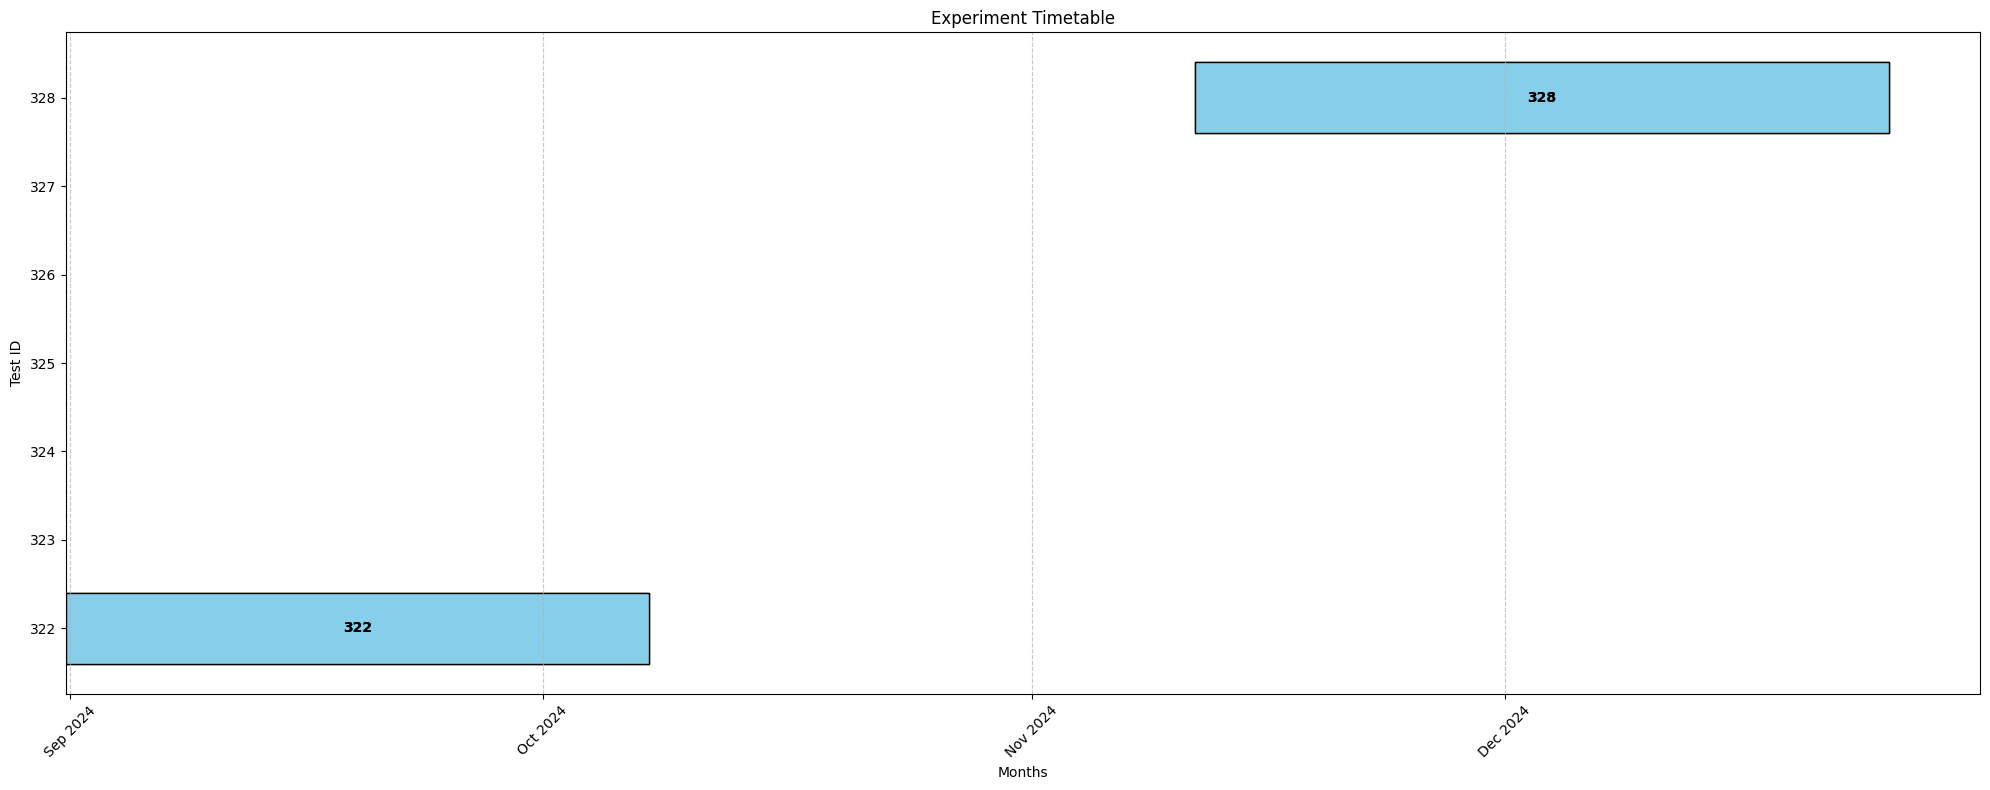

In [8]:
data_test = data_test[data_test['test_id'].isin([322,328])]

data_test["test_start_date"] = pd.to_datetime(data_test["test_start_date"], errors="coerce")
data_test["test_end_date"] = pd.to_datetime(data_test["test_end_date"], errors="coerce")

data_test["duration"] = (data_test["test_end_date"] - data_test["test_start_date"]).dt.days

data_test = data_test.sort_values(by="test_start_date")

fig, ax = plt.subplots(figsize=(20, 8))

for i, row in data_test.iterrows():
    start_date = row["test_start_date"]
    duration = row["duration"]
    test_id = row["test_id"]

    min_duration = max(duration, 1)  

    ax.barh(test_id, min_duration, left=start_date, color="skyblue", edgecolor="black")

    ax.text(start_date + pd.Timedelta(days=min_duration / 2), test_id, str(test_id),
            va='center', ha='center', fontsize=10, color="black", fontweight='bold')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Months")
ax.set_ylabel("Test ID")
ax.set_title("Experiment Timetable")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout() 
plt.show()


In [12]:
import numpy as np
from scipy.stats import chi2_contingency

# Example contingency table for overlapping users
#           Test B: Control | Test B: Treatment
# Test A: Control     3000  |        1000
# Test A: Treatment   1000  |        3000

table = np.array([
    [407395, 21689],  # Test A: Control
    [21647, 407683]   # Test A: Treatment
])

chi2_stat, p_value, dof, expected = chi2_contingency(table)

print(f"Chi-squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print("Expected counts under independence:")
print(expected)

Chi-squared Statistic: 693817.4570
P-value: 0.0000
Expected counts under independence:
[[214459.52364244 214624.47635756]
 [214582.47635756 214747.52364244]]


In [58]:
final

,entity_id,test_id_1,test_id_2,test_1_start_date,test_1_end_date,test_2_start_date,test_2_end_date,test_1_duration,test_2_duration,test_overlap_days,...,var_B_treatment_only_ppu_test_1,var_B_treatment_only_ppu_test_2,var_A_B_control_flgp_test_1,var_A_B_control_flgp_test_2,var_A_B_treatment_flgp_test_1,var_A_B_treatment_flgp_test_2,var_A_treatment_only_flgp_test_1,var_A_treatment_only_flgp_test_2,var_B_treatment_only_flgp_test_1,var_B_treatment_only_flgp_test_2
0,AP_PA,104,105,2024-04-17 14:07:22.173605 UTC,2024-06-04 15:17:43.705706 UTC,2024-04-17 15:18:19.207959 UTC,2024-06-27 17:03:31.102255 UTC,48.0,71.0,48,...,172.345082,18.108564,141.554685,9.256727,592.798521,735.851784,496.231988,25.076934,155.103412,24.753584
1,AP_PA,104,106,2024-04-17 14:07:22.173605 UTC,2024-06-04 15:17:43.705706 UTC,2024-04-25 15:29:41.094685 UTC,2024-06-03 22:01:23.503710 UTC,48.0,47.0,40,...,8.906337,125.424743,25.405652,228.399022,321.081831,249.551866,44.281884,802.674768,8.601066,161.846575
2,AP_PA,104,107,2024-04-17 14:07:22.173605 UTC,2024-06-04 15:17:43.705706 UTC,2024-05-14 17:58:39.430056 UTC,2024-07-12 23:11:40.629985 UTC,48.0,86.0,21,...,181.308257,136.145544,177.512884,17.997153,182.536114,31.915588,192.311975,52.077048,167.927102,136.684711
3,AP_PA,104,108,2024-04-17 14:07:22.173605 UTC,2024-06-04 15:17:43.705706 UTC,2024-06-12 20:18:03.573920 UTC,2024-06-14 19:23:33.543478 UTC,48.0,58.0,0,...,NaN,NaN,NaN,NaN,70.383465,0.271532,NaN,NaN,NaN,NaN
4,AP_PA,104,109,2024-04-17 14:07:22.173605 UTC,2024-06-04 15:17:43.705706 UTC,2024-06-12 20:17:53.156670 UTC,2024-08-01 01:32:32.969644 UTC,48.0,105.0,0,...,NaN,NaN,192.321749,204.670050,207.128421,216.083538,211.469759,197.509836,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,YS_TR,259,263,2025-01-29 10:04:55.571139 UTC,2025-02-17 07:23:45.713795 UTC,2025-02-24 15:30:07.932630 UTC,2025-03-10 11:07:44.858549 UTC,18.0,40.0,0,...,NaN,NaN,73.883140,48.312358,NaN,NaN,72.447219,47.359917,NaN,NaN
1219,YS_TR,259,264,2025-01-29 10:04:55.571139 UTC,2025-02-17 07:23:45.713795 UTC,2025-02-24 15:30:36.159337 UTC,NaN,18.0,NaN,0,...,NaN,NaN,57.452948,49.113503,NaN,NaN,59.933047,44.349970,NaN,NaN
1220,YS_TR,260,263,2025-01-29 10:07:36.014421 UTC,2025-02-17 07:24:12.208311 UTC,2025-02-24 15:30:07.932630 UTC,2025-03-10 11:07:44.858549 UTC,18.0,40.0,0,...,85.484162,45.925043,76.917304,46.593387,69.969052,47.171276,NaN,NaN,86.305054,46.748378
1221,YS_TR,260,264,2025-01-29 10:07:36.014421 UTC,2025-02-17 07:24:12.208311 UTC,2025-02-24 15:30:36.159337 UTC,NaN,18.0,NaN,0,...,58.754081,58.399336,53.324998,45.922392,60.712818,54.557217,NaN,NaN,58.567751,58.975664


In [43]:
data_1 = pd.read_csv('/Users/shazeb.asad/Downloads/test_data_1.csv')
data_2 = pd.read_csv('/Users/shazeb.asad/Downloads/test_data_2.csv')
data_3 = pd.read_csv('/Users/shazeb.asad/Downloads/test_data_3.csv')

tmp = pd.concat([data_1, data_2])

final = pd.concat([tmp, data_3])

In [44]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm


results = {
    "entity_id": [],
    "test_id_1": [],
    "test_id_2": [],
    "stat": [],
    "p_value": []
}

for i, row in tqdm(final.iterrows()):
    try:
        allocation = np.array(
            [
                [row["A_B_control_only"], row["B_treatment_only"]], 
                [row["A_treatment_only"], row["A_B_treatment"]]
            ],
            dtype=float  # Force numeric type
        )

        stat, p_value, dof, exp_freq = sp.stats.chi2_contingency(
            allocation, 
            correction=True
        )

        results["entity_id"].append(row["entity_id"])
        results["test_id_1"].append(row["test_id_1"])
        results["test_id_2"].append(row["test_id_2"])
        results["stat"].append(stat)
        results["p_value"].append(p_value)

    except Exception as e:
        print(f"row {i} failed with {e}")


0it [00:00, ?it/s]/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/scipy/stats/contingency.py:135: RuntimeWarning: invalid value encountered in divide
  expected = reduce(np.multiply, margsums) / observed.sum() ** (d - 1)
2024it [00:00, 10393.64it/s]

row 3 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 36 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 116 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 162 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 572 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 606 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 750 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 756 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 758 fai

5523it [00:00, 11417.44it/s]

row 2687 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 2688 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 2690 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 2703 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 2705 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 2798 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 2928 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 2974 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).


7823it [00:00, 11427.54it/s]

row 1657 failed with The internally computed table of expected frequencies has a zero element at (np.int64(1), np.int64(0)).
row 1668 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 1675 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 1677 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 1705 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 1712 failed with The internally computed table of expected frequencies has a zero element at (np.int64(1), np.int64(0)).
row 1732 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 1738 failed with The internally computed table of expected frequencies has a zero element at (np.int64(1), np.int64(0)).


10977it [00:00, 11378.41it/s]

row 5195 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).
row 5300 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5333 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5354 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5426 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5592 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5630 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).
row 5784 failed with The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).


In [37]:
results_df = pd.DataFrame(results)
results_df["is_sign"] = results_df["p_value"] < 0.05

In [45]:
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# Assume results_df is already created
p_values = results_df["p_value"]

# Identify valid (non-NaN) p-values
valid_mask = ~pd.isnull(p_values)
valid_p_values = p_values[valid_mask]

# Apply FDR correction only on valid p-values
rejected, p_values_corrected = fdrcorrection(
    valid_p_values, 
    alpha=0.05, 
    method='indep', 
    is_sorted=False
)

# Initialize full-size arrays with NaN
results_df["p_value_corrected"] = np.nan
results_df["rejected"] = False

# Fill corrected values into original DataFrame
results_df.loc[valid_mask, "p_value_corrected"] = p_values_corrected
results_df.loc[valid_mask, "rejected"] = rejected

In [39]:
# from statsmodels.stats.multitest import fdrcorrection

# rejected, p_values_corrected = fdrcorrection(
#     results_df["p_value"], 
#     alpha=0.05, 
#     method='indep', 
#     is_sorted=False
# )

In [51]:
results_df[results_df['p_value_corrected'] < 0.05]

,entity_id,test_id_1,test_id_2,p_value,is_sign,p_value_corrected,rejected,p_values_corrected,is_sign_corrected
3,AP_PA,104,109,0.000000e+00,True,0.000000e+00,True,NaN,False
7,AP_PA,105,106,0.000000e+00,True,0.000000e+00,True,NaN,False
9,AP_PA,105,108,8.107502e-16,True,4.521840e-15,True,NaN,False
12,AP_PA,105,111,2.043828e-89,True,1.275538e-88,True,NaN,False
13,AP_PA,105,112,5.824444e-16,True,3.250225e-15,True,NaN,False
...,...,...,...,...,...,...,...,...,...
10594,TB_OM,142,144,0.000000e+00,True,0.000000e+00,True,NaN,False
10595,TB_OM,143,144,0.000000e+00,True,0.000000e+00,True,NaN,False
10601,YS_TR,260,263,0.000000e+00,True,0.000000e+00,True,NaN,False
10602,YS_TR,260,264,0.000000e+00,True,0.000000e+00,True,NaN,False


In [48]:
# results_df["p_values_corrected"] = p_values_corrected
# results_df["is_sign_corrected"] = results_df["p_values_corrected"] < 0.05
# results_df

In [56]:
results_df['entity_id'].unique()

array(['AP_PA', 'EF_GR', 'FO_NO', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA',
       'FP_MM', 'FP_MY', 'FP_PH', 'FP_SG', 'FP_TH', 'FP_TW', 'HF_EG',
       'HS_SA', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'PY_AR', 'PY_CL',
       'PY_DO', 'PY_GT', 'PY_PE', 'PY_UY', 'TB_AE', 'TB_BH', 'TB_IQ',
       'TB_JO', 'TB_OM', 'YS_TR', 'DJ_CZ', 'FP_PK', 'FY_CY', 'GV_BA',
       'GV_BG', 'GV_HR', 'GV_KE', 'GV_MD', 'GV_ME', 'GV_RO', 'GV_RS',
       'PY_BO', 'PY_CR', 'PY_EC', 'PY_HN', 'PY_NI', 'PY_PY', 'PY_SV',
       'PY_VE', 'TB_KW', 'TB_QA', 'GV_MA', 'GV_NG', 'GV_PT', 'GV_TN'],
      dtype=object)

In [57]:
results_df[results_df['entity_id'] == 'FP_PH']

,entity_id,test_id_1,test_id_2,p_value,is_sign,p_value_corrected,rejected,p_values_corrected,is_sign_corrected
330,FP_PH,215,216,0.426014,False,0.891338,False,NaN,False
331,FP_PH,215,217,0.355827,False,0.832762,False,NaN,False
332,FP_PH,215,218,1.000000,False,1.000000,False,NaN,False
333,FP_PH,215,219,0.108442,False,0.413097,False,NaN,False
334,FP_PH,215,220,0.769268,False,1.000000,False,NaN,False
...,...,...,...,...,...,...,...,...,...
10111,FP_PH,346,347,0.000000,True,0.000000,True,NaN,False
10112,FP_PH,346,348,0.127461,False,0.464489,False,NaN,False
10113,FP_PH,346,349,0.000000,True,0.000000,True,NaN,False
10114,FP_PH,347,348,NaN,False,NaN,False,NaN,False
